<a href="https://colab.research.google.com/github/Sravya106/ML-DL/blob/main/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
import gensim.downloader as api
from PIL import Image
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input, Embedding,TextVectorization)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from tensorboard.plugins import projector

In [2]:
BATCH_SIZE=64

In [3]:
train_ds,val_ds,test_ds=tfds.load('imdb_reviews', split=['train', 'test[:50%]', 'test[50%:]'],as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.8M3058_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.8M3058_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.8M3058_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [4]:
train_ds


<_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [5]:
def standardization(input_data):
    '''
    Input: raw reviews
    output: standardized reviews
    '''
    lowercase=tf.strings.lower(input_data)
    no_tag=tf.strings.regex_replace(lowercase,"<[^>]+>","")
    output=tf.strings.regex_replace(no_tag,"[%s]"%re.escape(string.punctuation),"")

    return output

In [7]:
standardization(tf.constant("<u>In the movie?, </u>man called Tévèz, went to a friend’s pl**ce and they had a tensed discussion. I don’t love this movie! would you?<br> <br /><br />T"))

<tf.Tensor: shape=(), dtype=string, numpy=b'in the movie man called t\xc3\xa9v\xc3\xa8z went to a friend\xe2\x80\x99s plce and they had a tensed discussion i don\xe2\x80\x99t love this movie would you t'>

In [8]:
VOCAB_SIZE=10000
SEQUENCE_LENGTH=250
EMBEDDING_DIM=300

In [9]:
vectorize_layer=TextVectorization(
    standardize=standardization,
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH
)

In [10]:
training_data=train_ds.map(lambda x,y:x)### input x and y and outputx
vectorize_layer.adapt(training_data)

In [11]:
len(vectorize_layer.get_vocabulary())

10000

In [16]:
def vectorizer(review,label):
    return vectorize_layer(review),label

In [13]:
train_dataset=train_ds.map(vectorizer)
val_dataset=val_ds.map(vectorizer)

In [17]:
for review,label in train_dataset.take(1):
  print(review)
  print(label)

tf.Tensor(
[  10   13   33  411  384   17   89   26    1    8   32 1337 3521   40
  491    1  192   22   84  149   18   10  215  317   26   64  239  212
    8  484   54   64   84  111   95   21 5502   10   91  637  737   10
   17    7   33  393 9554  169 2443  406    2   87 1205  135   65  142
   52    2    1 7408   65  245   64 2832   16    1 2851    1    1 1415
 4969    3   39    1 1567   15 3521   13  156   18    4 1205  881 7874
    8    4   17   12   13 4037    5   98  145 1234   11  236  696   12
   48   22   91   37   10 7285  149   37 1337    1   49  396   11   95
 1148  841  140    9    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

In [19]:
train_dataset=train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset=val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

# GRU Model

In [20]:
EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),

    Bidirectional(GRU(64,return_sequences=True)),
    Bidirectional(GRU(32)),

    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 64)           640000    
                                                                 
 bidirectional (Bidirection  (None, 250, 128)          49920     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                31104     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In [21]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [22]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[])

Epoch 1/10
391/391 [==============================] - 337s 838ms/step - loss: 0.6917 - accuracy: 0.5296 - val_loss: 0.6851 - val_accuracy: 0.5857
Epoch 2/10
391/391 [==============================] - 302s 773ms/step - loss: 0.4565 - accuracy: 0.7820 - val_loss: 0.3399 - val_accuracy: 0.8551
Epoch 3/10
391/391 [==============================] - 307s 784ms/step - loss: 0.2740 - accuracy: 0.8956 - val_loss: 0.3373 - val_accuracy: 0.8665
Epoch 4/10
391/391 [==============================] - 303s 775ms/step - loss: 0.2282 - accuracy: 0.9187 - val_loss: 0.3935 - val_accuracy: 0.8547
Epoch 5/10
391/391 [==============================] - 297s 760ms/step - loss: 0.2016 - accuracy: 0.9294 - val_loss: 0.4063 - val_accuracy: 0.8586
Epoch 6/10
391/391 [==============================] - 303s 776ms/step - loss: 0.1746 - accuracy: 0.9421 - val_loss: 0.4068 - val_accuracy: 0.8574
Epoch 7/10
391/391 [==============================] - 305s 780ms/step - loss: 0.1552 - accuracy: 0.9494 - val_loss: 0.4438 -

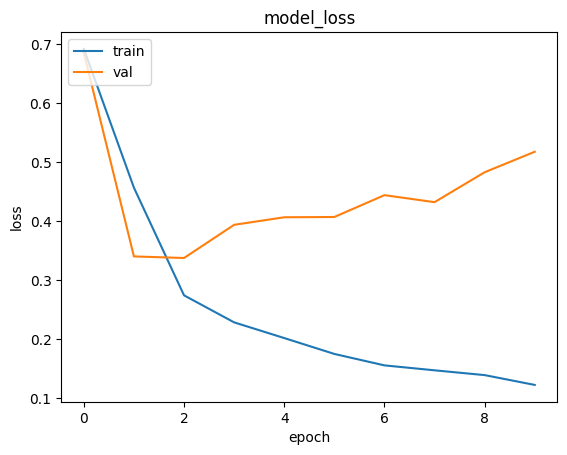

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

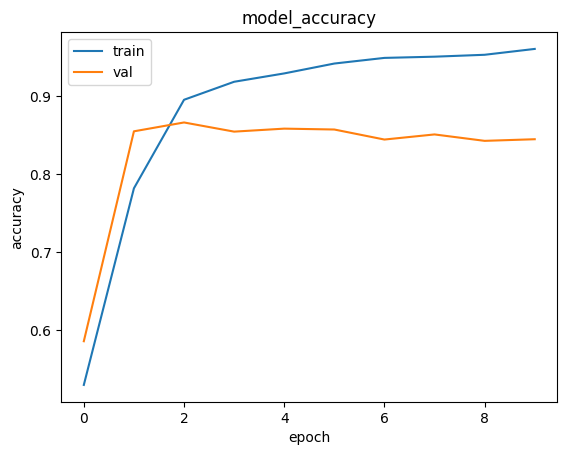

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
%load_ext tensorboard

In [30]:
pip install tensorboard

In [31]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
